In [2]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.dates import YearLocator, AutoDateFormatter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_pacf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import laplace_asymmetric
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
#import dataset
df_complete = pd.read_excel('EA_Inflation.xlsx')
df_complete.head()

,TIME,HICP,CISS,HICPlog,HICPannualized,HICPann/400
0,1991-01-01,61.43461,0.149332,4.117973,0.038614,0.000097
1,1991-02-01,61.70840,0.121447,4.122420,0.040292,0.000101
2,1991-03-01,61.70048,0.093995,4.122292,0.037812,0.000095
3,1991-04-01,61.91118,0.068052,4.125701,0.037925,0.000095
4,1991-05-01,62.17755,0.065581,4.129994,0.040115,0.000100


In [4]:
df = df_complete.drop('TIME', axis=1)
df.head()

,HICP,CISS,HICPlog,HICPannualized,HICPann/400
0,61.43461,0.149332,4.117973,0.038614,0.000097
1,61.70840,0.121447,4.122420,0.040292,0.000101
2,61.70048,0.093995,4.122292,0.037812,0.000095
3,61.91118,0.068052,4.125701,0.037925,0.000095
4,62.17755,0.065581,4.129994,0.040115,0.000100


In [5]:
hicp = df['HICP'].values.astype(float) 
ciss = df['CISS'].values.astype(float) 

hicp_an = df['HICPannualized'].values.astype(float) 
hicp_growth = df['HICPann/400'].values.astype(float) 
hicp_lag = np.roll(hicp_an, 1)
hicp_lag[0] = 0
hicp_lag_growth = np.roll(hicp_growth, 1)
hicp_lag[0] = 0

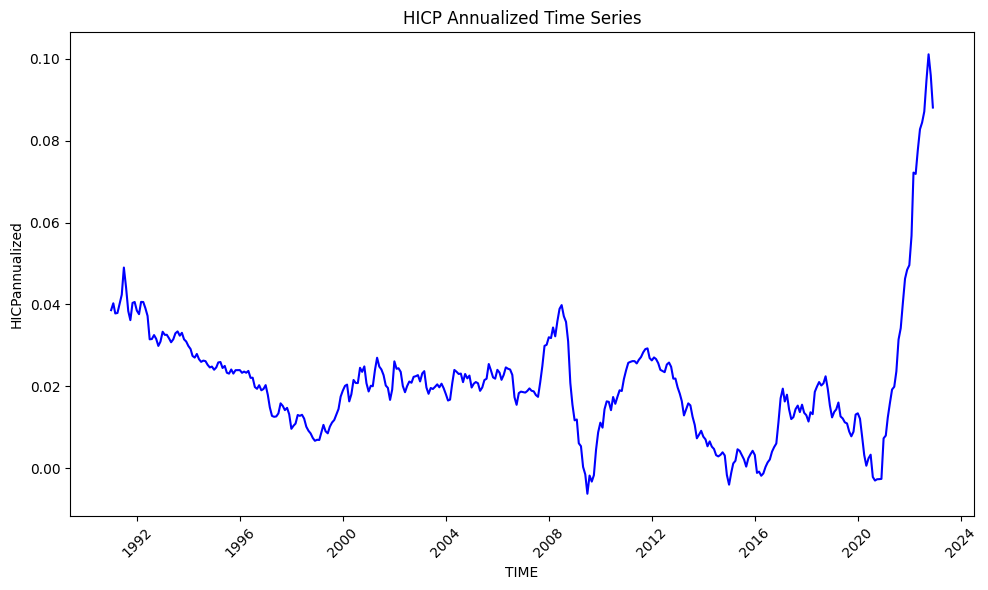

In [6]:
# Convert 'TIME' column to datetime
df_complete['TIME'] = pd.to_datetime(df_complete['TIME'])

# Create the fancy plot
plt.figure(figsize=(10, 6))
plt.plot(df_complete['TIME'], df_complete['HICPannualized'], linestyle='-', color='b')

# Set plot title and labels
plt.title('HICP Annualized Time Series')
plt.xlabel('TIME')
plt.ylabel('HICPannualized')

# Customize the x-axis tick labels (optional)
plt.xticks(rotation=45)


# Display the plot
plt.tight_layout()
plt.show()



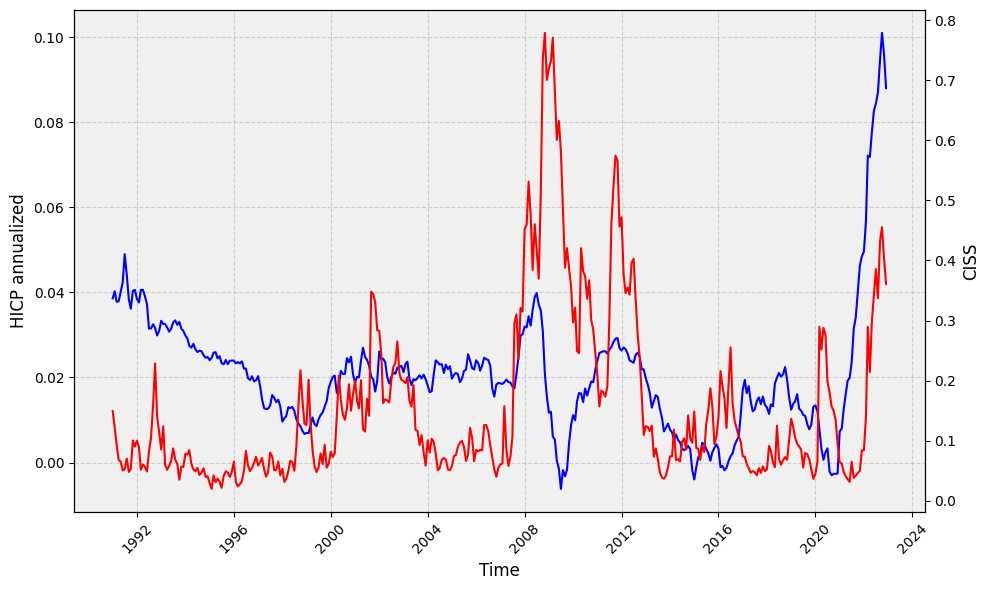

In [10]:

# Convert 'TIME' column to datetime
df_complete['TIME'] = pd.to_datetime(df_complete['TIME'])

# Create the fancy plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_complete['TIME'], df_complete['HICPannualized'], linestyle='-', color='b')

# Set plot title and labels
#ax.set_title('HICP Annualized Time Series and CISS', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('HICP annualized', fontsize=12)

# Customize the x-axis tick labels
ax.xaxis.set_tick_params(rotation=45, labelsize=10)

# Create a twin Axes for the secondary y-axis
ax2 = ax.twinx()
ax2.plot(df_complete['TIME'], df_complete['CISS'], linestyle='-', color='r')
ax2.set_ylabel('CISS', fontsize=12)

# Customize the x-axis tick labels
ax.xaxis.set_tick_params(rotation=45, labelsize=10)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Add a background color to the plot
ax.set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


In [54]:
''' QL regression with package'''
X = np.column_stack((np.ones_like(hicp_an), hicp_lag, ciss))

# Use the standardized variables in the regression analysis
quant_reg_1 = sm.QuantReg(hicp_an, X).fit(q=0.1)
quant_reg_5 = sm.QuantReg(hicp_an, X).fit(q=0.5)
quant_reg_9 = sm.QuantReg(hicp_an, X).fit(q=0.9)

# Print the summary of the quantile regression results
print(quant_reg_1.summary())
print(quant_reg_5.summary())
print(quant_reg_9.summary())  

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.7980
Model:                       QuantReg   Bandwidth:                    0.001179
Method:                 Least Squares   Sparsity:                      0.01174
Date:                Sun, 18 Jun 2023   No. Observations:                  384
Time:                        17:29:23   Df Residuals:                      381
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.000     -3.247      0.001      -0.002      -0.001
x1             0.9855      0.017     58.027      0.000       0.952       1.019
x2            -0.0058      0.001     -4.138      0.000      -0.009      -0.003
                         QuantReg Regression Results

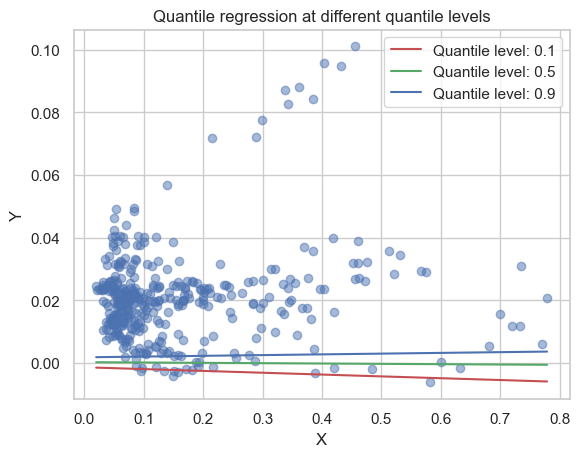

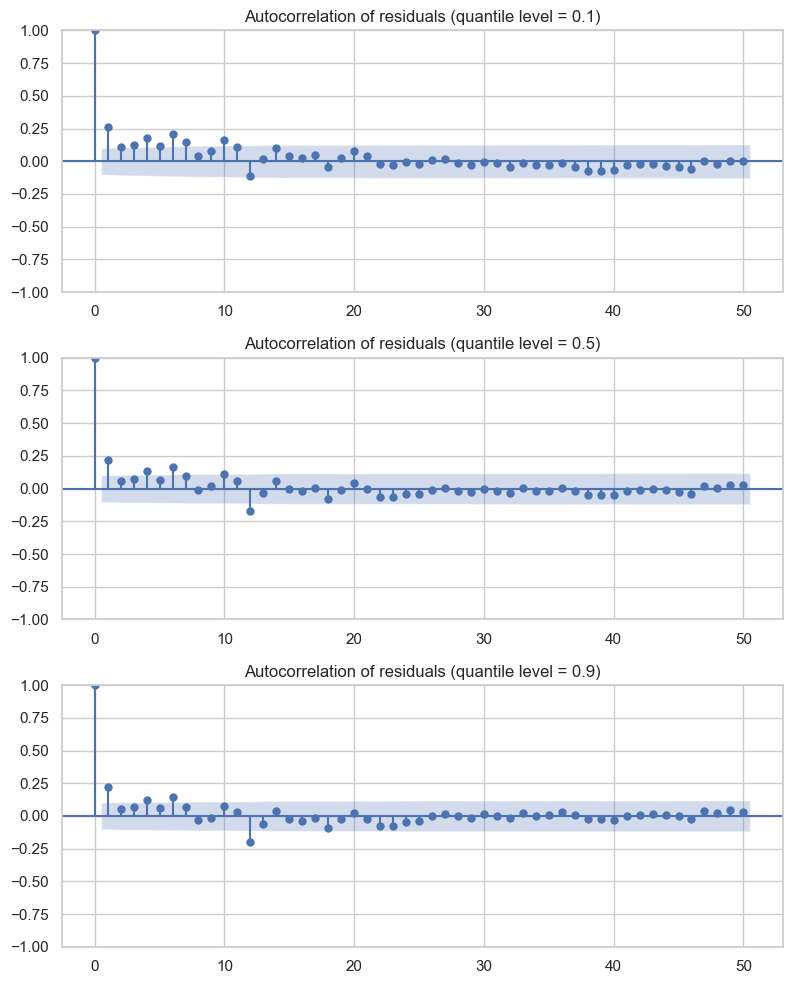

In [55]:
################################ Quantile regression plot ##############################
fig, ax = plt.subplots()
ax.scatter(ciss, hicp_an, alpha=0.5)

    # Generate x values for the regression lines
x_vals = np.linspace(np.min(ciss), np.max(ciss), 100)
y_vals_lag = np.linspace(np.min(hicp_lag), np.max(hicp_lag), 100)
    # Plot the regression lines
ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Quantile regression at different quantile levels')
plt.show()

################################ Autocorrelation of the residuals ##############################
residuals_1 = quant_reg_1.resid # Calculate the residuals
residuals_5 = quant_reg_5.resid # Calculate the residuals
residuals_9 = quant_reg_9.resid # Calculate the residuals

# Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
plot_acf(quant_reg_1.resid, lags=50, ax=ax[0])
ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
plot_acf(quant_reg_5.resid, lags=50, ax=ax[1])
ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
plot_acf(quant_reg_9.resid, lags=50, ax=ax[2])
ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
plt.tight_layout()
plt.show()

       lb_stat     lb_pvalue
1    26.115209  3.216405e-07
2    30.501920  2.380083e-07
3    36.237929  6.669284e-08
4    48.327605  8.064365e-10
5    53.329845  2.877660e-10
6    70.331295  3.496615e-13
7    78.607370  2.647996e-14
8    79.325487  6.682335e-14
9    81.603727  7.755835e-14
10   92.210124  1.950257e-15
11   96.729208  7.915585e-16
12  101.701530  2.582647e-16
13  101.855916  7.241672e-16
14  105.897192  3.480287e-16
15  106.458901  7.690015e-16
16  106.736928  1.864869e-15
17  107.631774  3.360679e-15
18  108.318984  6.465022e-15
19  108.617173  1.432516e-14
20  111.181232  1.195483e-14
21  111.831204  2.200082e-14
22  112.068944  4.707115e-14
23  112.365229  9.622193e-14
24  112.390068  2.151397e-13
25  112.535982  4.485808e-13
26  112.578923  9.554370e-13
27  112.724498  1.917083e-12
28  112.776406  3.918066e-12
29  113.101828  7.082668e-12
30  113.106495  1.424303e-11
31  113.222829  2.700339e-11
32  113.956724  4.008470e-11
33  114.002607  7.583297e-11
34  114.342531

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


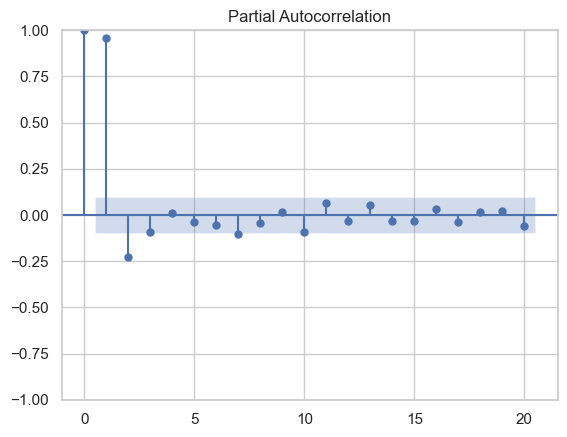

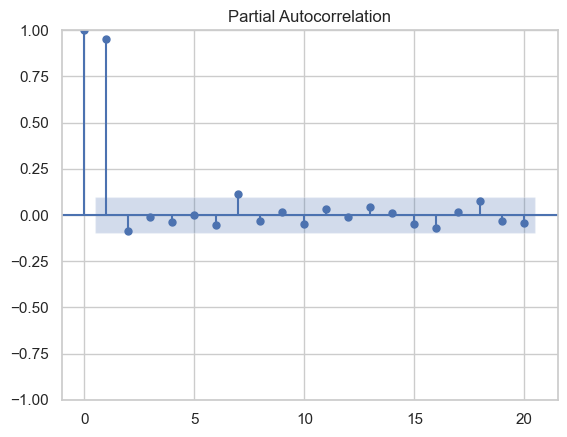

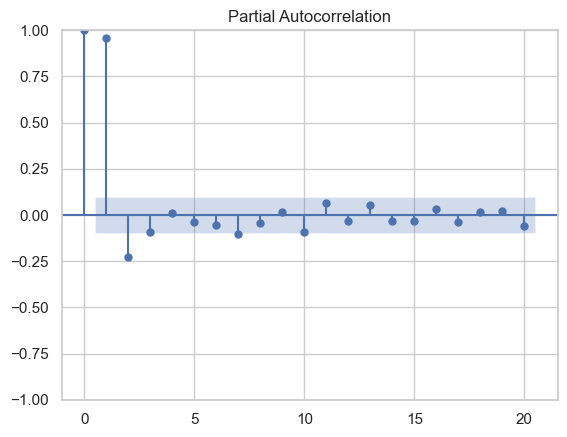

In [56]:
# Perform Ljung-Box test with up to 10 lags
lbtest = acorr_ljungbox(residuals_1, lags=50)

# Print p-values for each lag
print(lbtest)
# Perform Durbin-Watson test
dwtest = durbin_watson(residuals_1)

# Print test statistic
print(dwtest)

# Plot PACF of the time series
plot_pacf(ciss, lags=20)
plot_pacf(hicp_an, lags=20)

In [57]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['HICPannualized'].values
    T = min(M, len(y_dataset))
    y = df['HICPannualized'].values[:T]
    x = df['CISS'].values[:T]  # extract data

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        epsilon = np.random.randn(T) # Generate new errors for each iteration
        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.0077, 0.7821, -0.0271, 1])  # True parameters alpha, beta, gamma, theta
  # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")

In [58]:
M=1000
initial_params = 0.0003, 0.9951, -0.0011, 1, 0.0003, 0.9951, -0.0011, 1
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [-0.008627036037002635]
OLS beta_hat:  [0.013968111190326633]
OLS gamma_hat:  [-0.1584842210209773]
OLS theta_hat:  [1.0000000000000195]
GLS alpha_hat:  [-0.008629635650336677]
GLS beta_hat:  [0.013337028707090842]
GLS gamma_hat:  [-0.15861448624160465]
GLS theta_hat:  [0.9999999999994316]
OLS_bias_param_0 = 0.0163
OLS_bias_param_1 = 0.7681
OLS_bias_param_2 = 0.1314
OLS_bias_param_3 = -0.0000
OLS_RMSE = 0.3897
GLS_bias_param_0 = 0.0163
GLS_bias_param_1 = 0.7688
GLS_bias_param_2 = 0.1315
GLS_bias_param_3 = 0.0000
GLS_RMSE = 0.3901


In [60]:
def Laplace_estimation(df, p, M):

    def log_l_Asym_Lap(params, X, y):
        params = params
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1-p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2*p) / p * (1-p)
        ll -= np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(((y - X @ params - θ * z)**2)/(np.sqrt(τ_2)*np.sqrt(z))**2))
        return -ll

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['HICPannualized'].values
    T = min(M, len(y_dataset))
    y = df['HICPannualized'].values[:T]
    x = df['CISS'].values[:T]  # extract data
    #epsilon_y = df['epsilon_y'].values[:T]
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
    
        params0 = np.array([0.0003, 0.9951, -0.0011], dtype=float)  # Reshape to 1D array
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Nelder-Mead')  # minimize the negative log-likelihood
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1

        actuals = np.array([0.0003, 0.9951, -0.0011])  # True parameters alpha, beta, gamma
        biases = actuals - np.array(beta_laplace)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE
        rmse_matrix[i, :] = rmse  # Store RMSE values in the matrix

    print("Beta Matrix:")
    print(beta_matrix)
    print("\nRMSE Matrix:")
    print(rmse_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))
    print("\nMean of RMSE:")
    print(np.mean(rmse_matrix))

    return beta_matrix

result_matrix = Laplace_estimation(df, 0.5, 1000)


Beta Matrix:
[[ 3.000e-04  9.951e-01 -1.100e-03]
 [ 3.000e-04  9.951e-01 -1.100e-03]
 [ 3.000e-04  9.951e-01 -1.100e-03]
 ...
 [ 3.000e-04  9.951e-01 -1.100e-03]
 [ 3.000e-04  9.951e-01 -1.100e-03]
 [ 3.000e-04  9.951e-01 -1.100e-03]]

RMSE Matrix:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[ 3.000e-04  9.951e-01 -1.100e-03]

Mean of RMSE:
0.0


In [36]:
def EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior):
    y_dataset = df['HICPannualized'].values
    #T = min(M, len(y_dataset))
    T = len(y_dataset)
    y = df['HICPannualized'].values[:T]
    x = df['CISS'].values[:T]  # extract data
    y = np.array(y)
    x = np.array(x)
    β_values = np.zeros((1, 3))  # Array to store β parameters
    rmse_ = np.zeros((1, 3)) 
    τ_2 = 2 / (p * (1 - p))
    τ = np.sqrt(τ_2)
    θ = (1 - 2 * p) / (p * (1 - p))
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    y_lag = y_lag.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X = np.column_stack((np.ones_like(x), y_lag, x))
    l = np.ones((len(x), 1))
    U = np.zeros((len(x), len(x)))
    l = l.reshape((-1, 1))
    np.fill_diagonal(Σ, sigma_ini)
    np.random.seed(42)
    z = np.random.exponential(1, T)

    # EM Algorithm iterations
    for i in range(M):
        alpha = alpha_prior + (3 * n / 2)
        #gamma
        res = np.zeros((len(x), 1))  # Initialize as zeros
        denomin = np.zeros((len(x), 1))  # Initialize as zeros
        for j in range(T):  
            res[j] = (y[j] - X[j] @ β - θ * z[j]) ** 2
            denomin[j] = (2 * z[j] * τ_2) + z[j]
        gamma = gamma_prior + np.sum(res) / np.sum(denomin)  # Sum the arrays

        #print('gamma:', gamma)
        mode_sigma = gamma / (alpha + 1)
        sigma = mode_sigma

        u = (sigma * τ_2 * z) ** -1
        np.fill_diagonal(U, u)

        r = θ / (sigma * τ_2)
        m_ = Σ @ ((X.T @ U) @ y) - ((r) * (X.T @ l))
        β = m_
        #μ
        abso = np.zeros((len(x), 1))
        for j in range(T):  
            abso[j] = np.abs(y[j] - X[j] @ β)
        μ = np.sqrt(θ ** 2 + 2 * τ_2) / (np.sum(abso))
        #print('μ:', μ)
        λ = (θ ** 2 + 2 * τ_2) / (sigma * τ_2)
        mode_z_inverse = μ * (np.sqrt(1 + (9 * (μ ** 2)) / (4 * (λ ** 2))) - (3 * μ) / (4 * λ))
        z_inverse = mode_z_inverse
        z[i+1] = 1 / mode_z_inverse
        #z[i+1] = mode_z_inverse
        #print('z[i+1]:', z[i+1])
        β_values = np.concatenate((β_values, β.flatten()[:len(x)].reshape(1, -1)), axis=0)  # Store β parameters
        Σ = np.linalg.inv((X.T @ U) @ X)
        print(f'Iteration {i+1}: {β_values[-1]}')  # Print the β parameters for each iteration

        actuals = np.array([0.0003, 0.9951, -0.0011])  # True parameters alpha, beta, gamma
        biases = actuals - np.array(β)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE

        print("\nRMSE:")
        print(rmse)

        print("\nMean of RMSE:")
        print(np.mean(rmse))

    return β_values


In [37]:
n = 1000
p = 0.5
df = df.astype('float64')
M = 50 # Number of iterations
sigma_ini = 1.55
β = np.array([0.0003, 0.9951, -0.0011]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [33078.43363318  1065.76428744  6791.61925055]

RMSE:
19505.70500466726

Mean of RMSE:
19505.70500466726
Iteration 2: [-1.62795448e-08  6.60036784e-05 -8.13332496e-08]

RMSE:
0.5745089576970634

Mean of RMSE:
0.5745089576970634
Iteration 3: [-4.22196230e+00  1.70927255e+04 -2.12806037e+01]

RMSE:
9868.30655316839

Mean of RMSE:
9868.30655316839
Iteration 4: [-7.69656190e-05  3.05897103e-01 -3.46748740e-04]

RMSE:
0.5420056417050314

Mean of RMSE:
0.5420056417050314
Iteration 5: [-9.84387907e-04  3.65635480e+00 -2.22513746e-03]

RMSE:
1.9947943422891652

Mean of RMSE:
1.9947943422891652
Iteration 6: [-2.75440501e-04  1.05138524e+00 -4.06134373e-04]

RMSE:
0.6829250916908065

Mean of RMSE:
0.6829250916908065
Iteration 7: [-2.39208958e-04  1.03287570e+00  9.62404405e-04]

RMSE:
0.6762445919553355

Mean of RMSE:
0.6762445919553355
Iteration 8: [-3.31237787e-04  1.07367763e+00 -1.99706431e-03]

RMSE:
0.6910984752011001

Mean of RMSE:
0.6910984752011001
Iteration 9: [-2.62449540

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.30784336e+04,  1.06576429e+03,  6.79161925e+03],
       [-1.62795448e-08,  6.60036784e-05, -8.13332496e-08],
       [-4.22196230e+00,  1.70927255e+04, -2.12806037e+01],
       [-7.69656190e-05,  3.05897103e-01, -3.46748740e-04],
       [-9.84387907e-04,  3.65635480e+00, -2.22513746e-03],
       [-2.75440501e-04,  1.05138524e+00, -4.06134373e-04],
       [-2.39208958e-04,  1.03287570e+00,  9.62404405e-04],
       [-3.31237787e-04,  1.07367763e+00, -1.99706431e-03],
       [-2.62449540e-04,  1.06562651e+00, -1.59801767e-03],
       [-2.28824228e-04,  1.06224186e+00, -1.41581901e-03],
       [-4.07173781e-04,  9.94742625e-01,  3.69042484e-03],
       [-2.67308402e-04,  1.06070729e+00, -1.15825750e-03],
       [-2.70777546e-04,  1.05862881e+00, -9.83489660e-04],
       [-2.55879033e-04,  1.05129979e+00, -5.18104894e-04],
       [-2.56644678e-04,  1.05010357e+00, -4.31366005e-04],
       [-2.56756539e-04,  1.05023256e+00

In [39]:
# Split the data into features (a) and target (b))
a = df.drop(['HICPannualized'], axis=1)  # Exclude the target column
b = df['HICPannualized']  # Target column

# Split the data into training set and test set
a_train, a_test, b_train, b_test = train_test_split(a, b, test_size=0.3, random_state=42)

df_train = pd.concat([a_train, b_train], axis=1)
df_test = pd.concat([a_test, b_test], axis=1)
#print('a_train shape:', a_train.shape)
#print('b_test shape:', b_test.shape)
#print('a_train shape:', a_train.shape)
#print('b_test shape:', b_test.shape)

In [40]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['HICPannualized'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['HICPannualized'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))
        

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)
        
    return mse_list


In [63]:
df = pd.read_excel('EA_Inflation.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizons = [1, 2, 3, 4, 5, 6, 7, 8]
#0.0003, 0.9951, -0.0011

beta_lap = np.array([0.000300,  0.09510, -0.001100])
beta_em = np.array([-0.00026731, 1.0607072, -0.001158257])
beta_ols = np.array([-0.00862704, 0.01396811, -0.15848422])
beta_gls = np.array([-0.00862964, 0.01333702, -0.15861449])

betas = [beta_lap, beta_em, beta_ols, beta_gls]
beta_names = ['beta_lap', 'beta_em', 'beta_ols', 'beta_gls']

mse_values = []  # List to store the average MSE values for each horizon and beta combination

for beta, beta_name in zip(betas, beta_names):
    for horizon in horizons:
        mse_list = recursive_poos(df_complete, horizon, beta)
        avg_mse = np.mean(mse_list)
        mse_values.append((beta_name, horizon, avg_mse))

# Print the mse_values list
for beta_name, horizon, avg_mse in mse_values:
    print(f"Average MFSE for {beta_name}, horizon {horizon}: {avg_mse}")

Average MFSE for beta_lap, horizon 1: 0.001053311822276554
Average MFSE for beta_lap, horizon 2: 0.0010357121702087551
Average MFSE for beta_lap, horizon 3: 0.0010181186275539681
Average MFSE for beta_lap, horizon 4: 0.0009997606005380344
Average MFSE for beta_lap, horizon 5: 0.0009817878672149546
Average MFSE for beta_lap, horizon 6: 0.0009646273650587754
Average MFSE for beta_lap, horizon 7: 0.0009481074709265999
Average MFSE for beta_lap, horizon 8: 0.000932105660369583
Average MFSE for beta_em, horizon 1: 8.006441104600937e-05
Average MFSE for beta_em, horizon 2: 5.964445184942218e-05
Average MFSE for beta_em, horizon 3: 4.73223255645962e-05
Average MFSE for beta_em, horizon 4: 3.809614140997317e-05
Average MFSE for beta_em, horizon 5: 3.1995002956869654e-05
Average MFSE for beta_em, horizon 6: 2.7849724315844675e-05
Average MFSE for beta_em, horizon 7: 2.458861522467354e-05
Average MFSE for beta_em, horizon 8: 2.1893100318107152e-05
Average MFSE for beta_ols, horizon 1: 0.00544392

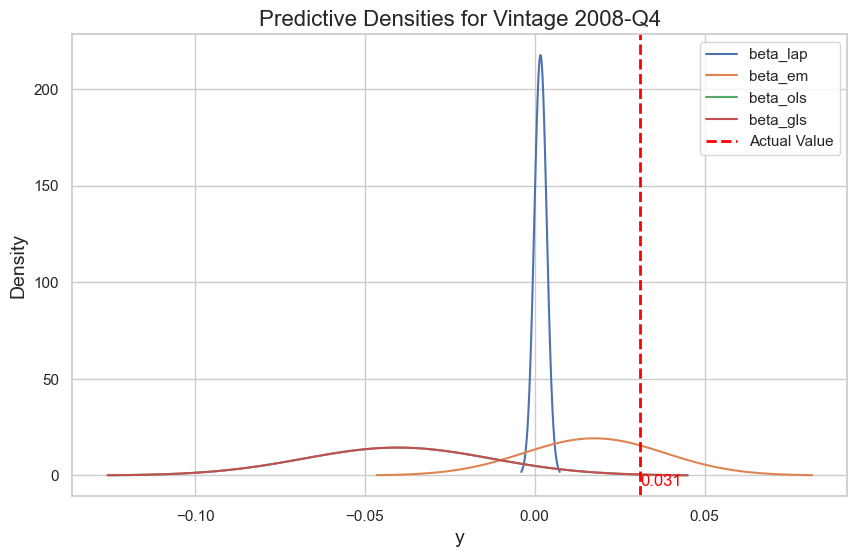

In [64]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []
    predictive_densities = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['HICPannualized'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['HICPannualized'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)

        if horizon == 1 and vintage == np.datetime64('2008-10-01'):
            predictive_density = norm(loc=np.mean(y_forecast), scale=np.std(y_forecast))
            predictive_densities.append(predictive_density)

    return mse_list, predictive_densities


df = pd.read_excel('EA_Inflation.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizon = 1

beta_lap = np.array([0.000300,  0.09510, -0.001100])
beta_em = np.array([-0.00026731, 1.0607072, -0.001158257])
beta_ols = np.array([-0.00862704, 0.01396811, -0.15848422])
beta_gls = np.array([-0.00862964, 0.01333702, -0.15861449])

betas = [beta_lap, beta_em, beta_ols, beta_gls]
beta_names = ['beta_lap', 'beta_em', 'beta_ols', 'beta_gls']

models = len(betas)

# Select the vintage for the plot
vintage = np.datetime64('2008-10-01')
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictive densities for each model
for i, (beta, beta_name) in enumerate(zip(betas, beta_names)):
    mse_list, predictive_densities = recursive_poos(df_complete, horizon, beta)

    if predictive_densities:
        predictive_density = predictive_densities[0]
        y = np.linspace(predictive_density.ppf(0.001), predictive_density.ppf(0.999), 100)
        density = predictive_density.pdf(y)
        # Plot the density
        ax.plot(y, density, label=f'{beta_name}')

# Plot the actual value of y as a vertical line
actual_value = df.loc[vintage, 'HICPannualized']
#ax.text(actual_value, 0.05, f'Actual Value: {actual_value:.3f}', color='red', fontsize=12, ha='center', va='center')
ax.text(actual_value, 0.95, f'{actual_value:.3f}', color='red', fontsize=12,
        ha='left', va='top')


ax.axvline(actual_value, color='red', linestyle='--', linewidth=2, label='Actual Value')

# Set the plot title and labels
ax.set_title(f'Predictive Densities for Vintage 2008-Q4', fontsize=16)
ax.set_xlabel('y', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
plt.show()


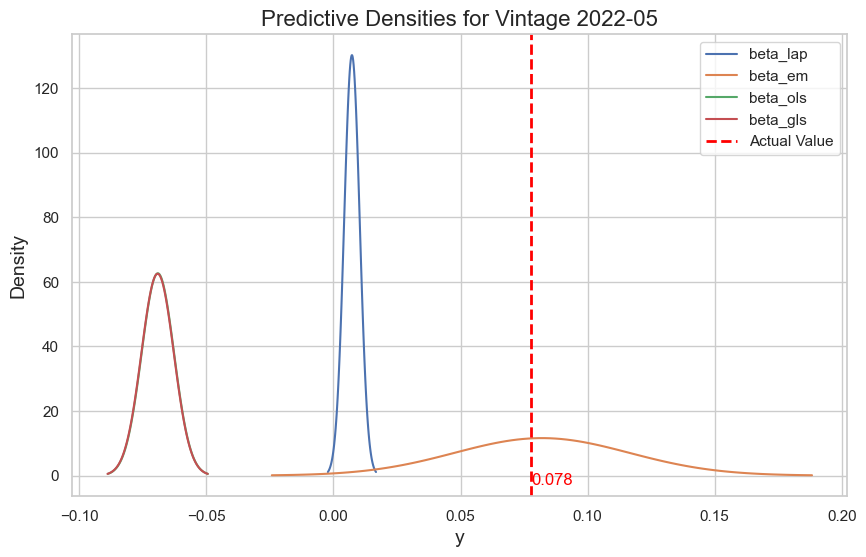

In [72]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []
    predictive_densities = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['HICPannualized'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['HICPannualized'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)

        if horizon == 1 and vintage == np.datetime64('2022-05-01'):
            predictive_density = norm(loc=np.mean(y_forecast), scale=np.std(y_forecast))
            predictive_densities.append(predictive_density)

    return mse_list, predictive_densities


df = pd.read_excel('EA_Inflation.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizon = 1

beta_lap = np.array([0.000300,  0.09510, -0.001100])
beta_em = np.array([-0.00026731, 1.0607072, -0.001158257])
beta_ols = np.array([-0.00862704, 0.01396811, -0.15848422])
beta_gls = np.array([-0.00862964, 0.01333702, -0.15861449])

betas = [beta_lap, beta_em, beta_ols, beta_gls]
beta_names = ['beta_lap', 'beta_em', 'beta_ols', 'beta_gls']

models = len(betas)

# Select the vintage for the plot
vintage = np.datetime64('2022-05-01')
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictive densities for each model
for i, (beta, beta_name) in enumerate(zip(betas, beta_names)):
    mse_list, predictive_densities = recursive_poos(df_complete, horizon, beta)

    if predictive_densities:
        predictive_density = predictive_densities[0]
        y = np.linspace(predictive_density.ppf(0.001), predictive_density.ppf(0.999), 100)
        density = predictive_density.pdf(y)
        # Plot the density
        ax.plot(y, density, label=f'{beta_name}')

# Plot the actual value of y as a vertical line
actual_value = df.loc[vintage, 'HICPannualized']
#ax.text(actual_value, 0.05, f'Actual Value: {actual_value:.3f}', color='red', fontsize=12, ha='center', va='center')
ax.text(actual_value, 0.95, f'{actual_value:.3f}', color='red', fontsize=12,
        ha='left', va='top')


ax.axvline(actual_value, color='red', linestyle='--', linewidth=2, label='Actual Value')

# Set the plot title and labels
ax.set_title(f'Predictive Densities for Vintage 2022-05', fontsize=16)
ax.set_xlabel('y', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
plt.show()

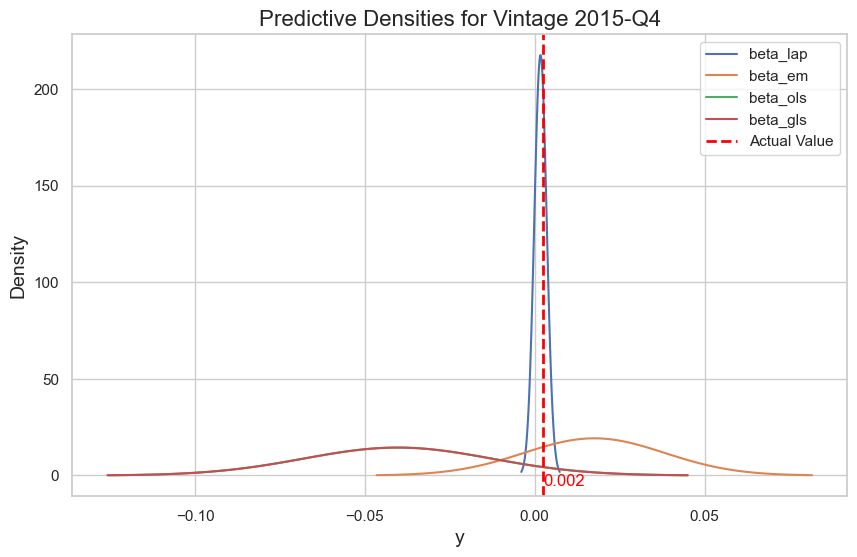

In [65]:
#Plot Vintage 2015-Q4
vintage = np.datetime64('2015-10-01')
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictive densities for each model
for i, (beta, beta_name) in enumerate(zip(betas, beta_names)):
    mse_list, predictive_densities = recursive_poos(df_complete, horizon, beta)

    if predictive_densities:
        predictive_density = predictive_densities[0]
        y = np.linspace(predictive_density.ppf(0.001), predictive_density.ppf(0.999), 100)
        density = predictive_density.pdf(y)
        # Plot the density
        ax.plot(y, density, label=f'{beta_name}')

# Plot the actual value of y as a vertical line
actual_value = df.loc[vintage, 'HICPannualized']
ax.axvline(actual_value, color='red', linestyle='--', linewidth=2, label='Actual Value')
ax.text(actual_value, 0.95, f'{actual_value:.3f}', color='red', fontsize=12,
        ha='left', va='top')

# Set the plot title and labels
ax.set_title(f'Predictive Densities for Vintage 2015-Q4', fontsize=16)
ax.set_xlabel('y', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
plt.show()

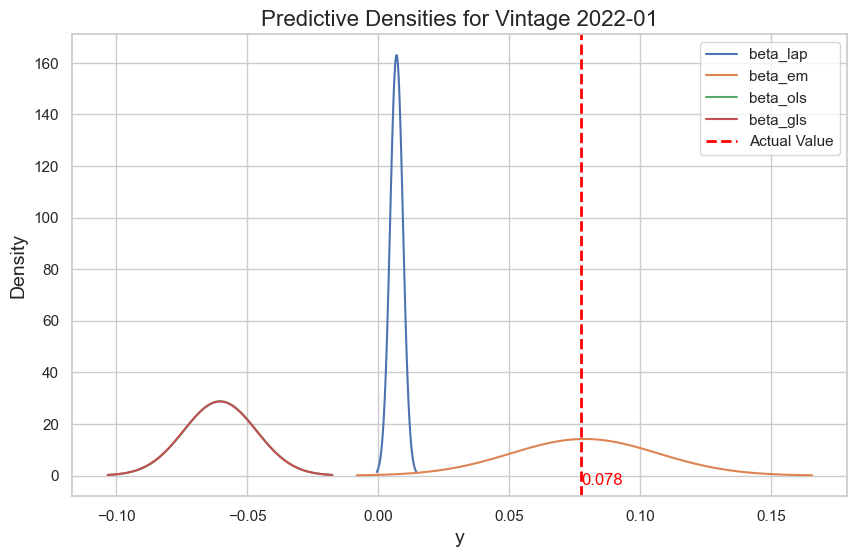

In [71]:
#Plot Vintage 2015-Q4
vintage = np.datetime64('2022-05-01')
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictive densities for each model
for i, (beta, beta_name) in enumerate(zip(betas, beta_names)):
    mse_list, predictive_densities = recursive_poos(df_complete, horizon, beta)

    if predictive_densities:
        predictive_density = predictive_densities[0]
        y = np.linspace(predictive_density.ppf(0.001), predictive_density.ppf(0.999), 100)
        density = predictive_density.pdf(y)
        # Plot the density
        ax.plot(y, density, label=f'{beta_name}')

# Plot the actual value of y as a vertical line
actual_value = df.loc[vintage, 'HICPannualized']
ax.axvline(actual_value, color='red', linestyle='--', linewidth=2, label='Actual Value')
ax.text(actual_value, 0.95, f'{actual_value:.3f}', color='red', fontsize=12,
        ha='left', va='top')

# Set the plot title and labels
ax.set_title(f'Predictive Densities for Vintage 2022-01', fontsize=16)
ax.set_xlabel('y', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
plt.show()